# Random Forest – Wine Quality

Ce notebook applique **Random Forest** selon le cahier des charges :
- Classification robuste
- Importance des features
- Support binaire ET multi-class
- Évaluation avec Accuracy, F1-score
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
# Racine du projet (dossier contenant src/ et dataset/)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project.")
from preprocessing import load_data, clean_data, scale_features, split_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///c:/Users/pc/Desktop/ML-project/classification/mlflow.db")
mlflow.set_experiment("wine-quality-random-forest")

2026/02/14 17:15:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:15:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:15:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:15:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:15:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:15:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:15:02 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:15:02 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/classification/mlruns/6', creation_time=1770930229914, experiment_id='6', last_update_time=1770930229914, lifecycle_stage='active', name='wine-quality-random-forest', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

X = df.drop(columns=["quality"])
y_binary = (df["quality"] >= 6).astype(int)  # Binaire
y_multiclass = df["quality"]  # Multi-class
feature_names = X.columns.tolist()

# Normalisation
X_scaled, scaler = scale_features(X)

print(f"Dataset shape: {df.shape}")
print(f"Nombre de features: {len(feature_names)}")
print(f"\nRépartition classes binaires:")
print(y_binary.value_counts().sort_index())
print(f"\nRépartition classes multi-class:")
print(y_multiclass.value_counts().sort_index())

Dataset shape: (1359, 12)
Nombre de features: 11

Répartition classes binaires:
quality
0    640
1    719
Name: count, dtype: int64

Répartition classes multi-class:
quality
3     10
4     53
5    577
6    535
7    167
8     17
Name: count, dtype: int64


## 3. Test de différents hyperparamètres

n_estimators=50: Accuracy=0.739, F1=0.747
n_estimators=100: Accuracy=0.768, F1=0.774
n_estimators=200: Accuracy=0.761, F1=0.767
n_estimators=300: Accuracy=0.750, F1=0.757


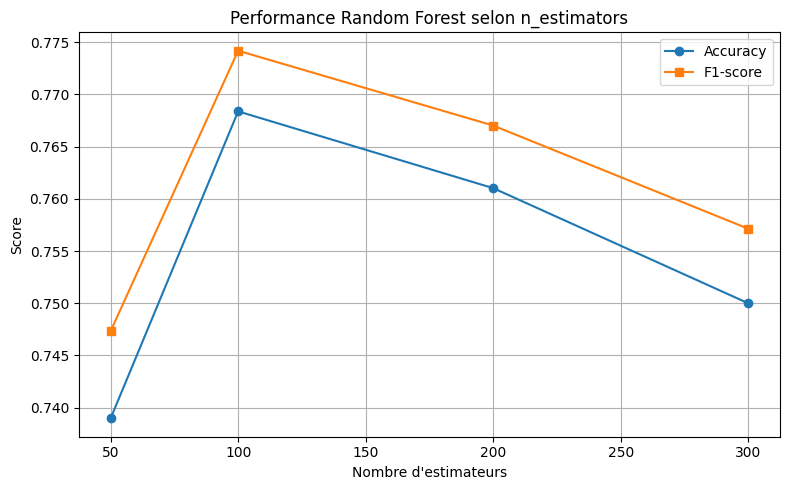

In [3]:
# Train/test split pour binaire
X_train_bin, X_test_bin, y_train_bin, y_test_bin = split_data(X_scaled, y_binary, test_size=0.2, random_state=42)

# Test de différents n_estimators
n_estimators_values = [50, 100, 200, 300]
results = []

for n_est in n_estimators_values:
    rf_test = RandomForestClassifier(n_estimators=n_est, random_state=42)
    rf_test.fit(X_train_bin, y_train_bin)
    y_pred_test = rf_test.predict(X_test_bin)
    
    acc = accuracy_score(y_test_bin, y_pred_test)
    f1 = f1_score(y_test_bin, y_pred_test)
    
    results.append({'n_estimators': n_est, 'accuracy': acc, 'f1': f1})
    print(f"n_estimators={n_est}: Accuracy={acc:.3f}, F1={f1:.3f}")

# Visualisation
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 5))
plt.plot(results_df['n_estimators'], results_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['n_estimators'], results_df['f1'], marker='s', label='F1-score')
plt.xlabel('Nombre d\'estimateurs')
plt.ylabel('Score')
plt.title('Performance Random Forest selon n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("randomforest_hyperparams.png")
plt.show()

## 4. Classification binaire

In [4]:
# Random Forest avec n_estimators=200 (optimal)
rf_clf_binary = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=10)
rf_clf_binary.fit(X_train_bin, y_train_bin)

y_pred_binary = rf_clf_binary.predict(X_test_bin)

# Métriques
acc_binary = accuracy_score(y_test_bin, y_pred_binary)
f1_binary = f1_score(y_test_bin, y_pred_binary)
precision_binary = precision_score(y_test_bin, y_pred_binary)
recall_binary = recall_score(y_test_bin, y_pred_binary)

print(f"=== Classification Binaire ===")
print(f"Accuracy: {acc_binary:.3f}")
print(f"F1-score: {f1_binary:.3f}")
print(f"Precision: {precision_binary:.3f}")
print(f"Recall: {recall_binary:.3f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test_bin, y_pred_binary))
print("\nRapport de classification:")
print(classification_report(y_test_bin, y_pred_binary))

=== Classification Binaire ===
Accuracy: 0.754
F1-score: 0.760
Precision: 0.785
Recall: 0.736

Matrice de confusion:
[[ 99  29]
 [ 38 106]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.72      0.77      0.75       128
           1       0.79      0.74      0.76       144

    accuracy                           0.75       272
   macro avg       0.75      0.75      0.75       272
weighted avg       0.76      0.75      0.75       272



## 5. Feature importance (selon cahier des charges)

Feature importance (Top 5):
                 feature  importance
10               alcohol    0.225617
9              sulphates    0.129349
1       volatile acidity    0.110507
6   total sulfur dioxide    0.093177
7                density    0.084097


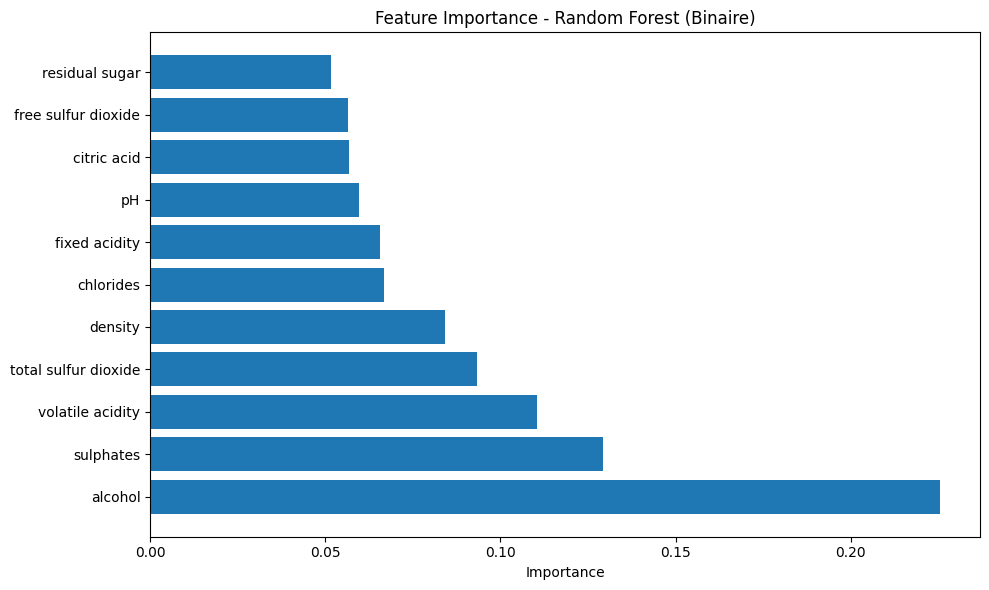

In [5]:
# Importance des features
feature_importance = rf_clf_binary.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature importance (Top 5):")
print(importance_df.head())

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest (Binaire)')
plt.tight_layout()
plt.savefig("randomforest_feature_importance_binary.png")
plt.show()

## 6. Visualisation matrice de confusion (binaire)

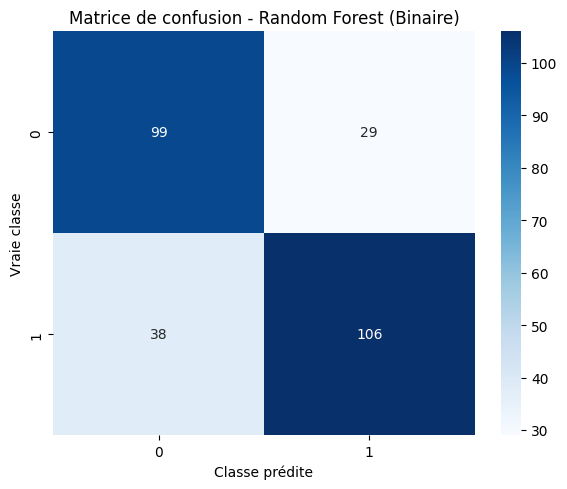

In [6]:
cm_binary = confusion_matrix(y_test_bin, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - Random Forest (Binaire)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.savefig("randomforest_confusion_matrix_binary.png")
plt.show()

## 7. Classification multi-class (selon cahier des charges)

In [7]:
# Train/test split pour multi-class
X_train_mc, X_test_mc, y_train_mc, y_test_mc = split_data(X_scaled, y_multiclass, test_size=0.2, random_state=42)

# Random Forest multi-class
rf_clf_multiclass = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=10)
rf_clf_multiclass.fit(X_train_mc, y_train_mc)

y_pred_multiclass = rf_clf_multiclass.predict(X_test_mc)

# Métriques
acc_multiclass = accuracy_score(y_test_mc, y_pred_multiclass)
f1_multiclass = f1_score(y_test_mc, y_pred_multiclass, average='macro')

print(f"=== Classification Multi-class ===")
print(f"Accuracy: {acc_multiclass:.3f}")
print(f"F1-score (macro): {f1_multiclass:.3f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test_mc, y_pred_multiclass))
print("\nRapport de classification:")
print(classification_report(y_test_mc, y_pred_multiclass))

=== Classification Multi-class ===
Accuracy: 0.592
F1-score (macro): 0.274

Matrice de confusion:
[[ 0  0  1  1  0  0]
 [ 0  0  7  4  0  0]
 [ 0  0 85 30  1  0]
 [ 0  0 32 66  9  0]
 [ 0  0  2 20 10  1]
 [ 0  0  0  2  1  0]]

Rapport de classification:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.67      0.73      0.70       116
           6       0.54      0.62      0.57       107
           7       0.48      0.30      0.37        33
           8       0.00      0.00      0.00         3

    accuracy                           0.59       272
   macro avg       0.28      0.28      0.27       272
weighted avg       0.55      0.59      0.57       272



C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

## 8. Feature importance (multi-class)

Feature importance (Multi-class, Top 5):
                 feature  importance
10               alcohol    0.170870
9              sulphates    0.117165
1       volatile acidity    0.106513
6   total sulfur dioxide    0.105984
7                density    0.084251


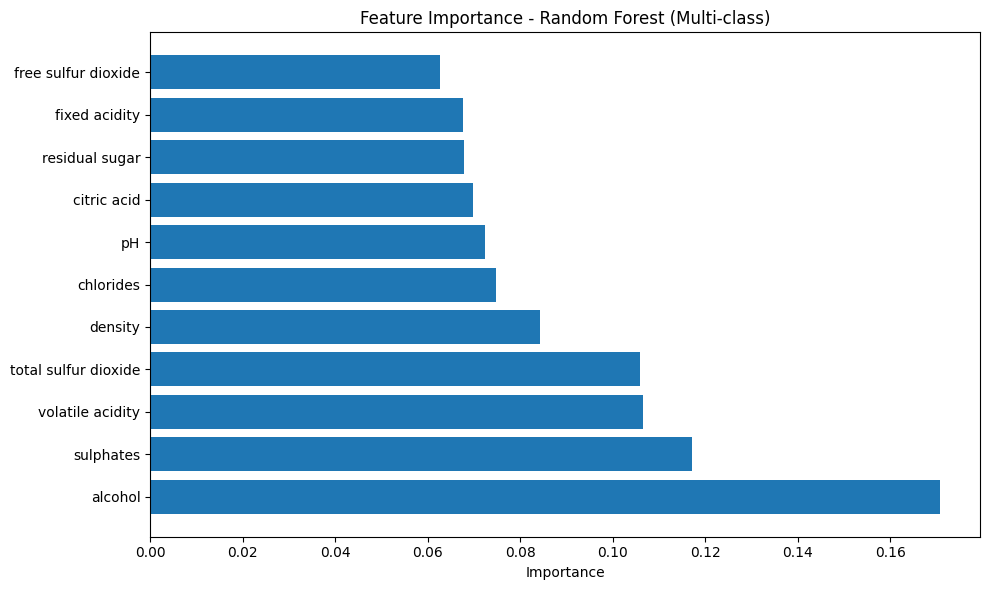

In [8]:
# Importance des features pour multi-class
feature_importance_mc = rf_clf_multiclass.feature_importances_
importance_df_mc = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance_mc
}).sort_values('importance', ascending=False)

print("Feature importance (Multi-class, Top 5):")
print(importance_df_mc.head())

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(importance_df_mc['feature'], importance_df_mc['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest (Multi-class)')
plt.tight_layout()
plt.savefig("randomforest_feature_importance_multiclass.png")
plt.show()

## 9. Visualisation matrice de confusion (multi-class)

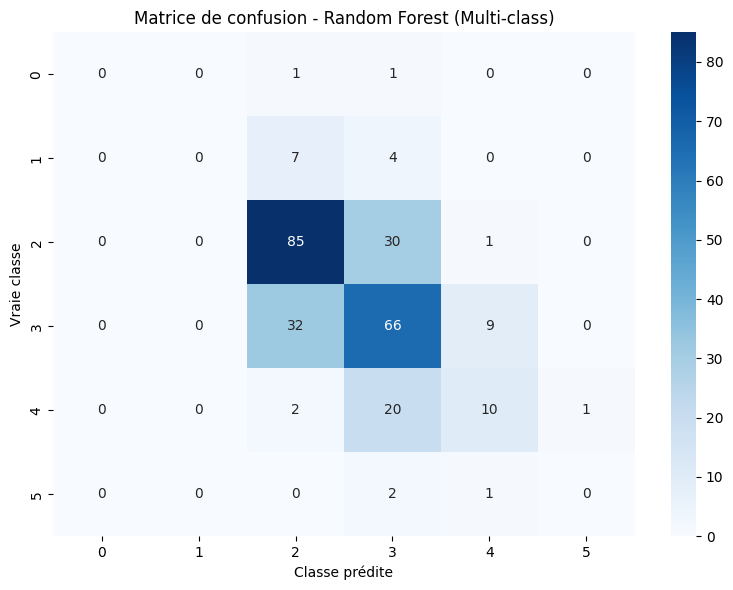

In [9]:
cm_multiclass = confusion_matrix(y_test_mc, y_pred_multiclass)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_multiclass, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - Random Forest (Multi-class)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.savefig("randomforest_confusion_matrix_multiclass.png")
plt.show()

## 10. MLflow tracking - Classification binaire

In [10]:
with mlflow.start_run(run_name="RandomForest_binary"):
    mlflow.log_params(rf_clf_binary.get_params())
    mlflow.log_metric("accuracy", float(acc_binary))
    mlflow.log_metric("f1_score", float(f1_binary))
    mlflow.log_metric("precision", float(precision_binary))
    mlflow.log_metric("recall", float(recall_binary))
    
    # Log feature importance
    for idx, row in importance_df.iterrows():
        mlflow.log_metric(f"feature_importance_{row['feature']}", float(row['importance']))
    
    mlflow.log_artifact("randomforest_hyperparams.png")
    mlflow.log_artifact("randomforest_feature_importance_binary.png")
    mlflow.log_artifact("randomforest_confusion_matrix_binary.png")
    mlflow.sklearn.log_model(rf_clf_binary, "random_forest_model_binary")
    print("MLflow run binaire terminé")

2026/02/14 17:15:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run binaire terminé


## 11. MLflow tracking - Classification multi-class

In [11]:
with mlflow.start_run(run_name="RandomForest_multiclass"):
    mlflow.log_params(rf_clf_multiclass.get_params())
    mlflow.log_metric("accuracy", float(acc_multiclass))
    mlflow.log_metric("f1_score_macro", float(f1_multiclass))
    
    # Log feature importance
    for idx, row in importance_df_mc.iterrows():
        mlflow.log_metric(f"feature_importance_{row['feature']}", float(row['importance']))
    
    mlflow.log_artifact("randomforest_feature_importance_multiclass.png")
    mlflow.log_artifact("randomforest_confusion_matrix_multiclass.png")
    mlflow.sklearn.log_model(rf_clf_multiclass, "random_forest_model_multiclass")
    print("MLflow run multi-class terminé")

2026/02/14 17:15:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow run multi-class terminé


## 12. Comparaison binaire vs multi-class

Comparaison des performances:
          Mode  Accuracy  F1-score
0      Binaire  0.753676  0.759857
1  Multi-class  0.591912  0.273979


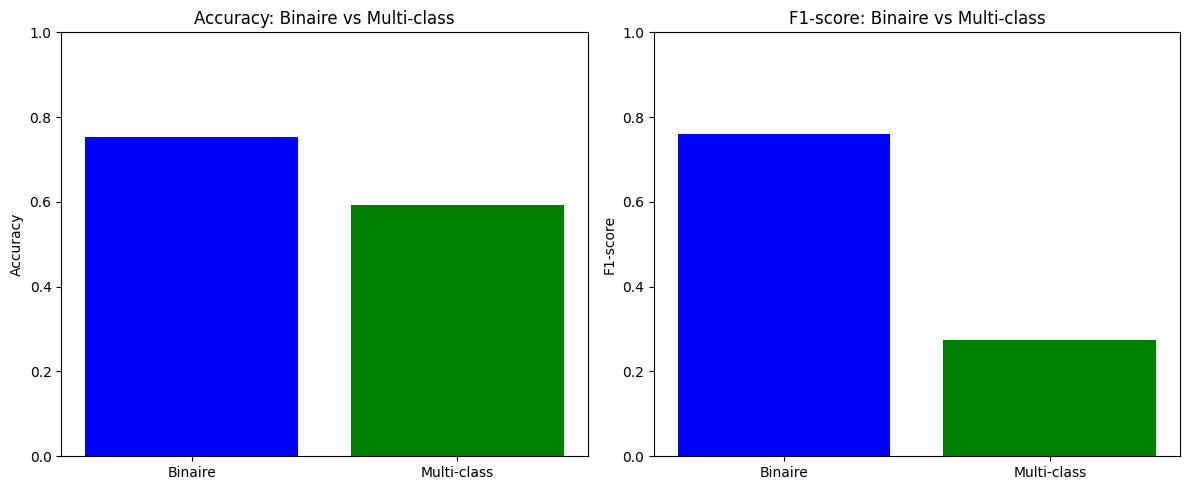

In [12]:
# Comparaison des performances
comparison = pd.DataFrame({
    'Mode': ['Binaire', 'Multi-class'],
    'Accuracy': [acc_binary, acc_multiclass],
    'F1-score': [f1_binary, f1_multiclass]
})

print("Comparaison des performances:")
print(comparison)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(comparison['Mode'], comparison['Accuracy'], color=['blue', 'green'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy: Binaire vs Multi-class')
axes[0].set_ylim([0, 1])

axes[1].bar(comparison['Mode'], comparison['F1-score'], color=['blue', 'green'])
axes[1].set_ylabel('F1-score')
axes[1].set_title('F1-score: Binaire vs Multi-class')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig("randomforest_comparison.png")
plt.show()